In [29]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler import CouplingMap
from qiskit.converters import dag_to_circuit
from qiskit.transpiler.layout import Layout
import numpy as np
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler.passes import (
    TrivialLayout,
    BasicSwap,
    ApplyLayout,
    SetLayout,
    SabreLayout,
    FullAncillaAllocation,
    EnlargeWithAncilla,
)
from qiskit.transpiler.passmanager import PassManager
from virtual_swap.deprecated.cns_sabre import CNS_SabreSwap

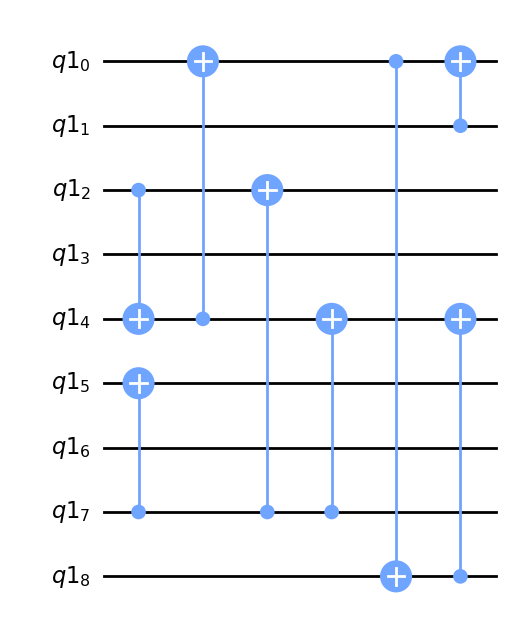

In [30]:
# load a dummy circuit
# generate network of random cnots
n, M = 3, 8
N = n**2
register = QuantumRegister(N)
qc = QuantumCircuit(register)

for _ in range(M):
    qc.cx(*np.random.choice(N, 2, replace=False))
qc.decompose().draw("mpl")

In [31]:
# load a dummy coupling map and layout
coupling = CouplingMap.from_line(N)
layout = Layout({q: i for q, i in zip(register, range(N))})

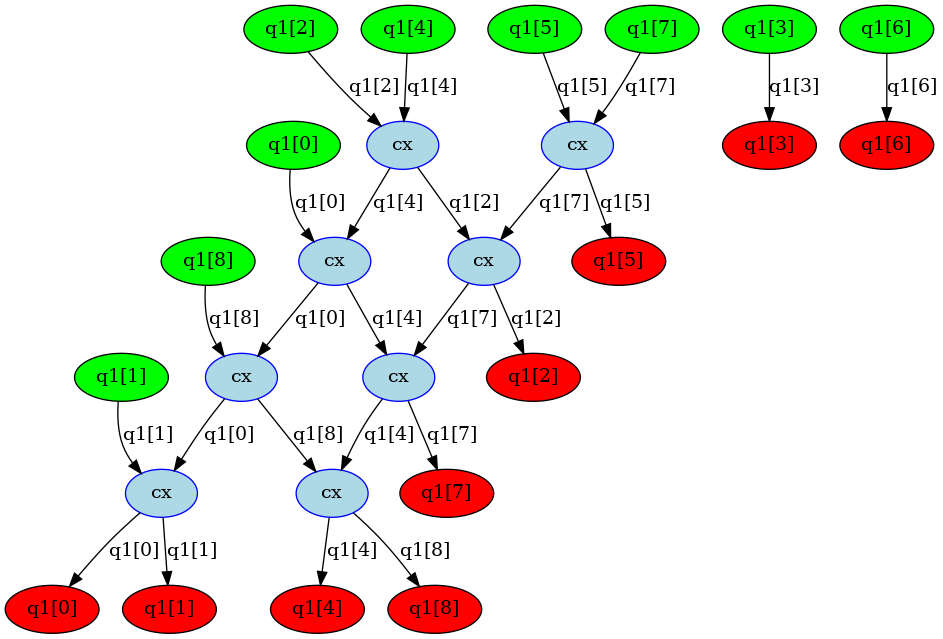

In [32]:
# print DAG
from qiskit.converters import circuit_to_dag

dag = circuit_to_dag(qc)
dag.draw("mpl")

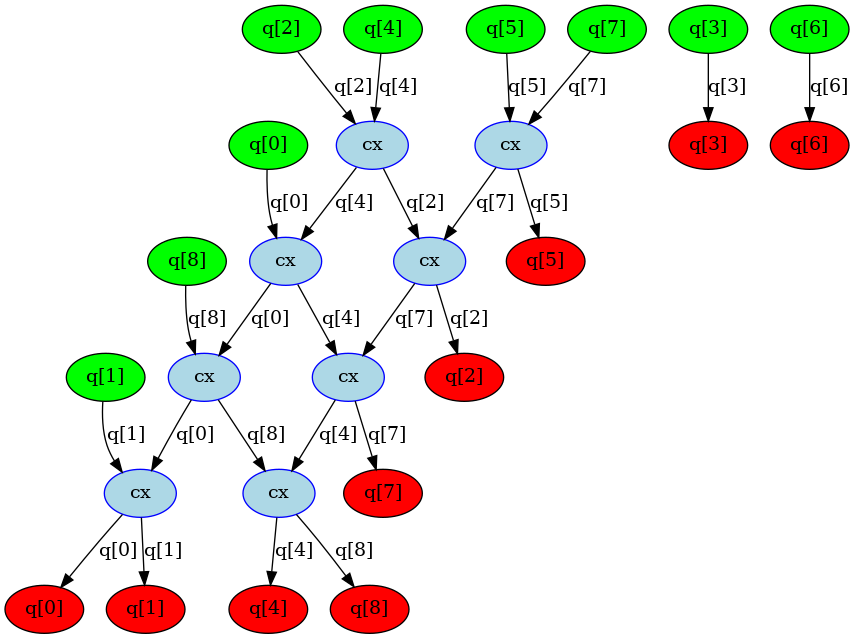

In [33]:
set_pass = SetLayout(layout)
dag_p = set_pass.run(dag)
apply_pass = ApplyLayout()
apply_pass.property_set = set_pass.property_set
dag_p = apply_pass.run(dag_p)
dag_p.draw("mpl")

In [34]:
# get layers of the DAG

"""A layer is a circuit whose gates act on disjoint qubits, i.e., a layer has depth 1. The total number of layers equals the circuit depth d. The layers are indexed from 0 to d-1 with the earliest layer at index 0. The layers are constructed using a greedy algorithm. Each returned layer is a dict containing {“graph”: circuit graph, “partition”: list of qubit lists}.

The returned layer contains new (but semantically equivalent) DAGOpNodes, DAGInNodes, and DAGOutNodes. These are not the same as nodes of the original dag, but are equivalent via DAGNode.semantic_eq(node1, node2)."""

# convert generator to list
layers = list(dag_p.layers())
for layer in layers:
    print(layer)

# # get serial layers
# """A serial layer is a circuit with one gate. The layers have the same structure as in layers()."""
# serial_layers = dag.serial_layers()
# for layer in serial_layers:
#     print(layer)

# # get multigraph layers
# multi_layers = dag.multigraph_layers()
# for layer in multi_layers:
#     print(layer)

{'graph': <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7ff6a5921fa0>, 'partition': [(Qubit(QuantumRegister(9, 'q'), 2), Qubit(QuantumRegister(9, 'q'), 4)), (Qubit(QuantumRegister(9, 'q'), 7), Qubit(QuantumRegister(9, 'q'), 5))]}
{'graph': <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7ff6a5921670>, 'partition': [(Qubit(QuantumRegister(9, 'q'), 4), Qubit(QuantumRegister(9, 'q'), 0)), (Qubit(QuantumRegister(9, 'q'), 7), Qubit(QuantumRegister(9, 'q'), 2))]}
{'graph': <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7ff6a59216a0>, 'partition': [(Qubit(QuantumRegister(9, 'q'), 7), Qubit(QuantumRegister(9, 'q'), 4)), (Qubit(QuantumRegister(9, 'q'), 0), Qubit(QuantumRegister(9, 'q'), 8))]}
{'graph': <qiskit.dagcircuit.dagcircuit.DAGCircuit object at 0x7ff6a59214f0>, 'partition': [(Qubit(QuantumRegister(9, 'q'), 1), Qubit(QuantumRegister(9, 'q'), 0)), (Qubit(QuantumRegister(9, 'q'), 8), Qubit(QuantumRegister(9, 'q'), 4))]}


In [35]:
# want to get topological distance from output F and inputs to F'
cns_sub = False
F = layers[0]["graph"]
F_prime = layers[1]["graph"]

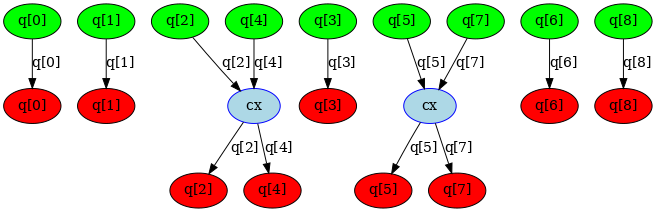

In [36]:
F.draw()

In [37]:
# F.output_map

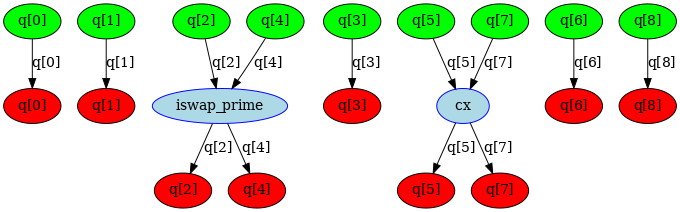

In [38]:
from virtual_swap.cns_transform import cns_transform
from qiskit.circuit.library.standard_gates import CXGate

# get cx from F
cns_sub = True
cns_cx = F.op_nodes(CXGate)[0]
F_cns = cns_transform(F, cns_cx)
F_cns.draw()

In [39]:
# def evaluate_layer(F, F_prime):
#     # cost from F:output -> F':input

In [40]:
# work on getting output permutations from a single layer
# this includes virtual swaps + slack swaps that don't affect the depth
v_to_p = layout.get_virtual_bits()

In [41]:
# FIXME, SABRE does meet in middle to increase parallelism
# we need to implement our own here,
# tests both CNS subs and slack swaps
swapper = BasicSwap(coupling)
if cns_sub:
    F_swapped = swapper.run(F_cns)
else:
    F_swapped = swapper.run(F)

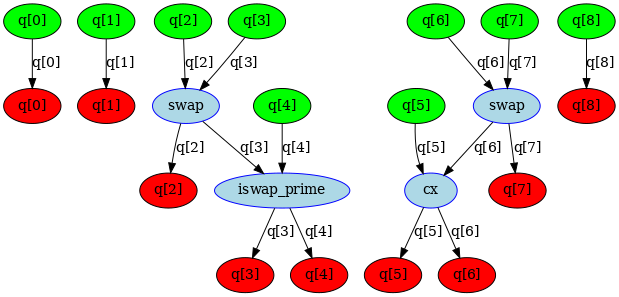

In [42]:
F_swapped.draw()

In [43]:
# swapper.property_set
# XXX this needs to be manually set following a swap pass
f_layout = swapper.property_set["final_layout"]
if cns_sub:
    temp = f_layout[cns_cx.qargs[0]]
    f_layout[cns_cx.qargs[0]] = f_layout[cns_cx.qargs[1]]
    f_layout[cns_cx.qargs[1]] = temp
print(f_layout)

Layout({
0: Qubit(QuantumRegister(9, 'q'), 0),
1: Qubit(QuantumRegister(9, 'q'), 1),
5: Qubit(QuantumRegister(9, 'q'), 5),
8: Qubit(QuantumRegister(9, 'q'), 8),
2: Qubit(QuantumRegister(9, 'q'), 3),
7: Qubit(QuantumRegister(9, 'q'), 6),
6: Qubit(QuantumRegister(9, 'q'), 7),
4: Qubit(QuantumRegister(9, 'q'), 2),
3: Qubit(QuantumRegister(9, 'q'), 4)
})


In [44]:
f_v_to_p = f_layout.get_virtual_bits()
print(f_v_to_p)
# for x in F_swapped.output_map.items():
#     print(x)

{Qubit(QuantumRegister(9, 'q'), 0): 0, Qubit(QuantumRegister(9, 'q'), 1): 1, Qubit(QuantumRegister(9, 'q'), 5): 5, Qubit(QuantumRegister(9, 'q'), 8): 8, Qubit(QuantumRegister(9, 'q'), 3): 2, Qubit(QuantumRegister(9, 'q'), 6): 7, Qubit(QuantumRegister(9, 'q'), 7): 6, Qubit(QuantumRegister(9, 'q'), 2): 4, Qubit(QuantumRegister(9, 'q'), 4): 3}


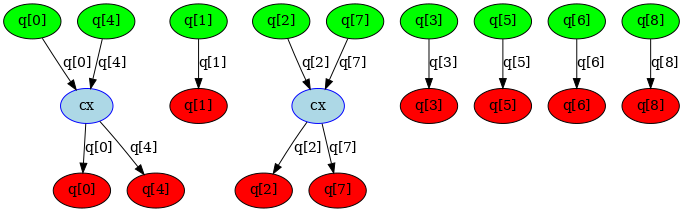

In [45]:
F_prime.draw()

In [46]:
trial_cost = 0
for x in F_prime.two_qubit_ops():
    print(f_v_to_p[x.qargs[0]], f_v_to_p[x.qargs[1]])
    print(coupling.distance(f_v_to_p[x.qargs[0]], f_v_to_p[x.qargs[1]]))
    trial_cost += coupling.distance(f_v_to_p[x.qargs[0]], f_v_to_p[x.qargs[1]])

    # FIXME do we want to return sum or max?
print(f"Trial cost", trial_cost)

3 0
3
6 4
2
Trial cost 5


In [47]:
# we need to define a cost function, intermediate layer to front layer
# the intermediate layer are gates that are physical on the topology
# the intermediate layer considers CNS subs and placement of SWAP gates
# once a permutation of the intermediate layer is found that minimizes cost to the front layer
# move the intermediate layer to the mapped dag, and front layer to intermediate layer
# once the front layer is empty, we are done

# open question, do we resolve all dependencies between intermediate and front layer at once?
# maybe we find a route for one gate, then pop the next gate in
# if we have a dynamic layer, makes reasoning about cost and when to move gates harder
# but that is how SABRE works, just by iteratively checking what is physical
# repeat pushing things over until we can't push anymore
# idk, I think conceptually treating it as a set of layers that need to be resolved is easier

# we define the minimum about of gates that add to the depth of the circuit for data movement
# types of SWAP paths we could take

# if 2 qubits can meet, they can SWAP together to meet at midpoint between them
# however, we might prefer to meet biased towards one qubit (for sake of lookahead)
# then, we incur a higher depth cost on this layer, but hopefully reduces lookahead cost

# so define a depth cost on the layer,

# maybe we just do the thing that tells us which decomp to use first